第一步：导入、观察、合并、清洗数据集：

In [1]:
# 导入库
import pandas as pd
import numpy as np
import time

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 导入train.csv
df_train = pd.read_csv('train.csv',parse_dates=[2])

/Users/zhanglijuan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# 查看df_train缺失情况与数据类型
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
# 将df_train按照'Store'和'Date'排序
df_train = df_train.sort_values(by=['Store','Date']).reset_index().drop('index',axis=1)

In [5]:
# 观察df_train前5行数据
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,1,3,2013-01-02,5530,668,1,0,0,1
2,1,4,2013-01-03,4327,578,1,0,0,1
3,1,5,2013-01-04,4486,619,1,0,0,1
4,1,6,2013-01-05,4997,635,1,0,0,1


In [6]:
# 导入store.csv
df_store = pd.read_csv('store.csv')

In [7]:
# 查看df_store缺失情况与数据类型
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
# df_store缺失值处理

## 将三个店铺缺失的CompetitionDistance填充为中位数
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(),inplace=True)
## 将CompetitionOpenSinceMonth和CompetitionOpenSinceYear缺失值用中位数填充
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].fillna(df_store['CompetitionOpenSinceMonth'].median()).astype('int')
df_store['CompetitionOpenSinceYear'] = df_store['CompetitionOpenSinceYear'].fillna(df_store['CompetitionOpenSinceYear'].median()).astype('int')
## 将Promo2SinceYear、Promo2SinceWeek和PromoInterval缺失值用0填充
df_store['Promo2SinceYear'] = df_store['Promo2SinceYear'].fillna(0).astype('int')
df_store['Promo2SinceWeek'] = df_store['Promo2SinceWeek'].fillna(0).astype('int')
df_store['PromoInterval'].fillna('0',inplace=True)

In [9]:
# 观察df_store前5行数据
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,0,0,0
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,0,0,0
4,5,a,a,29910.0,4,2015,0,0,0,0


In [10]:
# 导入各连锁店对应的州数据集
df_state = pd.read_csv('store_state.csv')

In [11]:
# 查看df_state缺失情况与数据类型
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 2 columns):
Store    1115 non-null int64
State    1115 non-null object
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [12]:
# 查看各州连锁店数量
df_state['State'].value_counts()

NW       286
BY       180
SH       115
HE       112
BE        92
SN        75
BW        73
ST        56
RP        40
TH        36
HH        28
HB,NI     22
Name: State, dtype: int64

In [13]:
# 导入test.csv
df_test = pd.read_csv('test.csv',parse_dates=[3])

In [14]:
# 查看df_test缺失情况与数据类型
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [15]:
# 将df_test按照'Store'和'Date'排序
df_test = df_test.sort_values(by=['Store','Date']).reset_index().drop('index',axis=1)

In [16]:
# df_test缺失值处理

## 将df_test中‘Open’字段缺失值填充为1，全部认为是开业状态
df_test['Open'].fillna(1,inplace=True)
## 添加目标字段’Sales’，默认待预测销售额初值为0
df_test['Sales'] = 0

In [17]:
# 观察df_test前5行数据
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,40233,1,6,2015-08-01,1.0,0,0,1,0
1,39377,1,7,2015-08-02,0.0,0,0,1,0
2,38521,1,1,2015-08-03,1.0,1,0,1,0
3,37665,1,2,2015-08-04,1.0,1,0,1,0
4,36809,1,3,2015-08-05,1.0,1,0,1,0


In [18]:
# 合并上述数据集作为总预测特征集

## df_store + df_state ——> df_store_state
df_store_state = df_store.merge(df_state,on='Store') 

## df_train + df_store_state + df_weather ——> df_train_store
df_train_store = df_train.merge(df_store_state,on='Store',how='left')

## df_test + df_store_state + df_weather ——> df_test_store
df_test_store = df_test.merge(df_store_state,on='Store',how='left')

## df_train_store + df_test_store ——> df
df = pd.concat([df_train_store,df_test_store],sort=True)

In [19]:
# 查看df缺失情况与数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 20 columns):
Assortment                   1058297 non-null object
CompetitionDistance          1058297 non-null float64
CompetitionOpenSinceMonth    1058297 non-null int64
CompetitionOpenSinceYear     1058297 non-null int64
Customers                    1017209 non-null float64
Date                         1058297 non-null datetime64[ns]
DayOfWeek                    1058297 non-null int64
Id                           41088 non-null float64
Open                         1058297 non-null float64
Promo                        1058297 non-null int64
Promo2                       1058297 non-null int64
Promo2SinceWeek              1058297 non-null int64
Promo2SinceYear              1058297 non-null int64
PromoInterval                1058297 non-null object
Sales                        1058297 non-null int64
SchoolHoliday                1058297 non-null int64
State                        1058297 non

In [20]:
# 观察df前5行数据
df.head()

,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Id,Open,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,State,StateHoliday,Store,StoreType
0,a,1270.0,9,2008,0.0,2013-01-01,2,NaN,0.0,0,0,0,0,0,0,1,HE,a,1,c
1,a,1270.0,9,2008,668.0,2013-01-02,3,NaN,1.0,0,0,0,0,0,5530,1,HE,0,1,c
2,a,1270.0,9,2008,578.0,2013-01-03,4,NaN,1.0,0,0,0,0,0,4327,1,HE,0,1,c
3,a,1270.0,9,2008,619.0,2013-01-04,5,NaN,1.0,0,0,0,0,0,4486,1,HE,0,1,c
4,a,1270.0,9,2008,635.0,2013-01-05,6,NaN,1.0,0,0,0,0,0,4997,1,HE,0,1,c


In [21]:
# 数据清洗

## 查看列'StateHoliday'唯一值
df['StateHoliday'].unique() 

array(['a', '0', 'b', 'c', 0], dtype=object)

In [22]:
## 将列'StateHoliday'中0转换为'0'
df['StateHoliday'].replace({0:'0'},inplace=True)

In [23]:
# 数据类型转换

df['Open'] = df['Open'].astype('int')

第二步：探索性分析（EDA）：

1.不同时间粒度的销售额周期性、趋势性分析：

In [24]:
# 将Date设置为索引，以便实现降采样
df_1 = df[df['Date']<'2015-08-01'].set_index('Date')

/Users/zhanglijuan/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


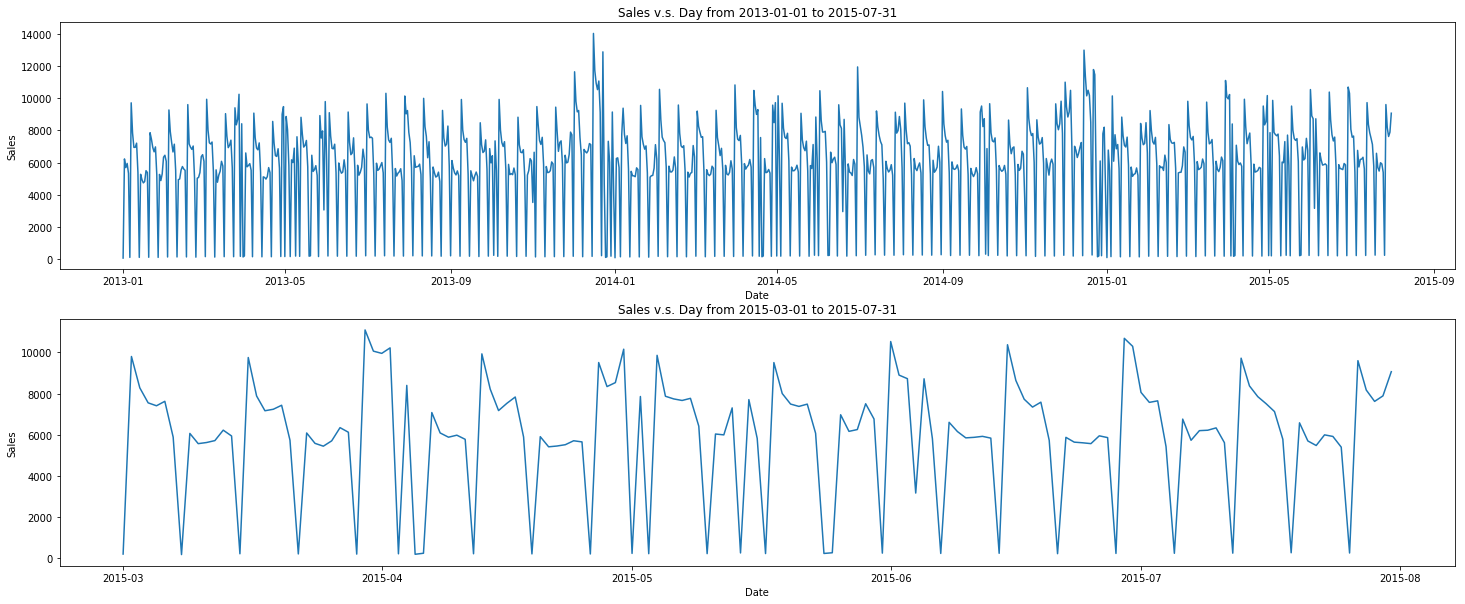

In [25]:
# 总体日均销售额变化
sale_day = df_1['Sales'].resample('D').mean().reset_index()

## 绘制2013-01-01至2015-07-31日均销售额线图
fig,(ax1,ax2)= plt.subplots(2,1,figsize=(25,10))
ax1.plot(sale_day['Date'],sale_day['Sales'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.set_title('Sales v.s. Day from 2013-01-01 to 2015-07-31')
## 绘制2015-03-01至2015-07-31日均销售额线图
ax2.plot(sale_day[sale_day['Date']>='2015-03-01']['Date'],sale_day[sale_day['Date']>='2015-03-01']['Sales'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
ax2.set_title('Sales v.s. Day from 2015-03-01 to 2015-07-31');

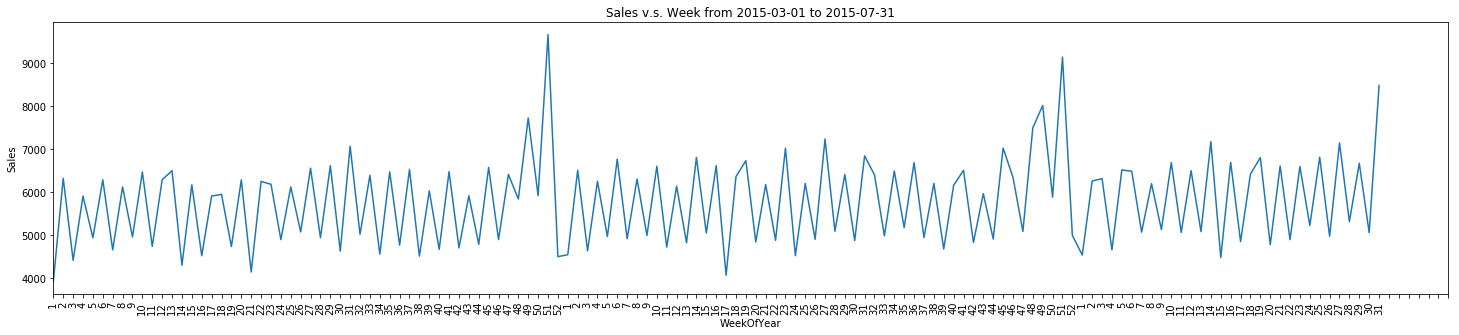

In [26]:
# 总体周均销售额变化
sale_week = df_1['Sales'].resample('W').mean().reset_index()

## 绘制2013-01-01至2015-07-31周均销售额线图
fig,ax = plt.subplots(figsize=(25,5))
sale_week['Sales'].plot()
plt.xticks(ticks=np.arange(142),labels=sale_week['Date'].dt.week,rotation=90)
plt.xlabel('WeekOfYear')
plt.ylabel('Sales')
plt.title('Sales v.s. Week from 2015-03-01 to 2015-07-31');

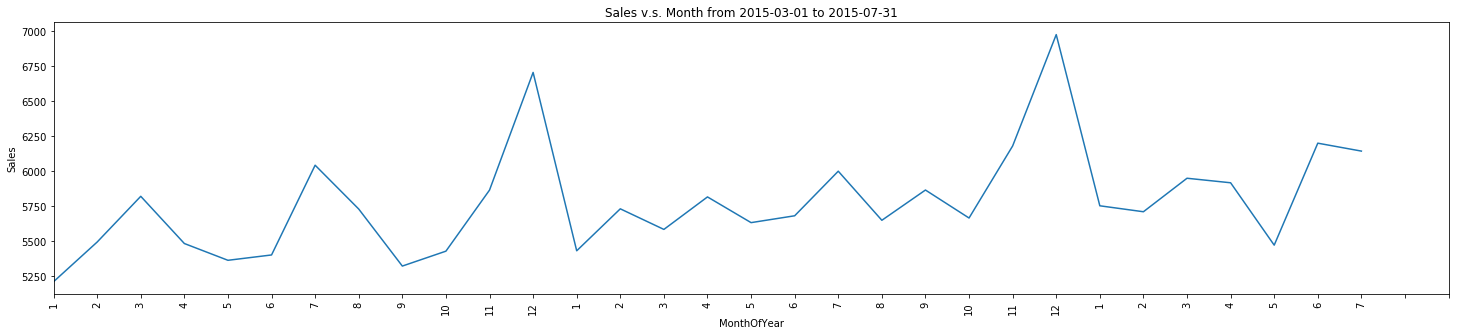

In [27]:
# 总体月均销售额变化
sale_month = df_1['Sales'].resample('M').mean().reset_index()

## 绘制2013-01-01至2015-07-31月均销售额线图
fig,ax = plt.subplots(figsize=(25,5))
sale_month['Sales'].plot()
plt.xticks(ticks=np.arange(33),labels=sale_month['Date'].dt.month,rotation=90)
plt.xlabel('MonthOfYear')
plt.ylabel('Sales')
plt.title('Sales v.s. Month from 2015-03-01 to 2015-07-31');

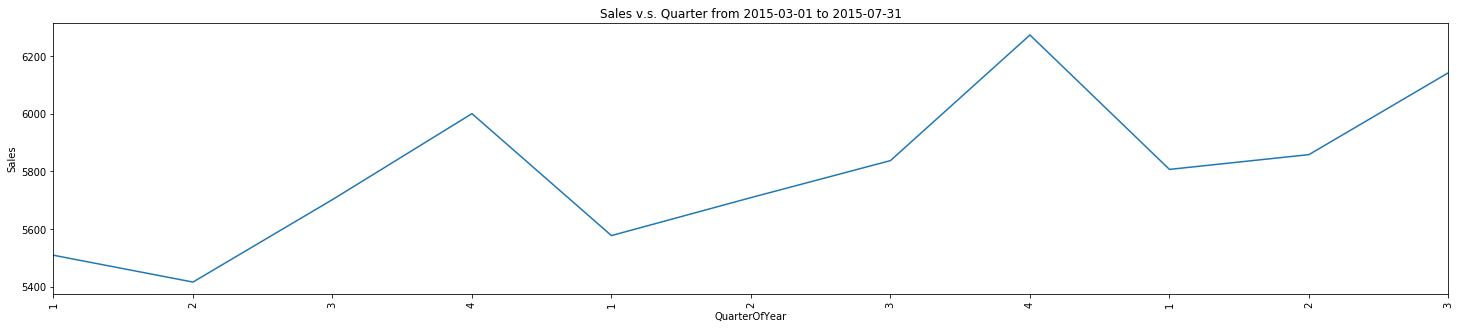

In [28]:
# 总体季均销售额变化
sale_quarter = df_1['Sales'].resample('Q').mean().reset_index()

## 绘制2013-01-01至2015-07-31季均销售额线图
fig,ax = plt.subplots(figsize=(25,5))
sale_quarter['Sales'].plot()
plt.xticks(ticks=np.arange(11),labels=sale_quarter['Date'].dt.quarter,rotation=90)
plt.xlabel('QuarterOfYear')
plt.ylabel('Sales')
plt.title('Sales v.s. Quarter from 2015-03-01 to 2015-07-31');

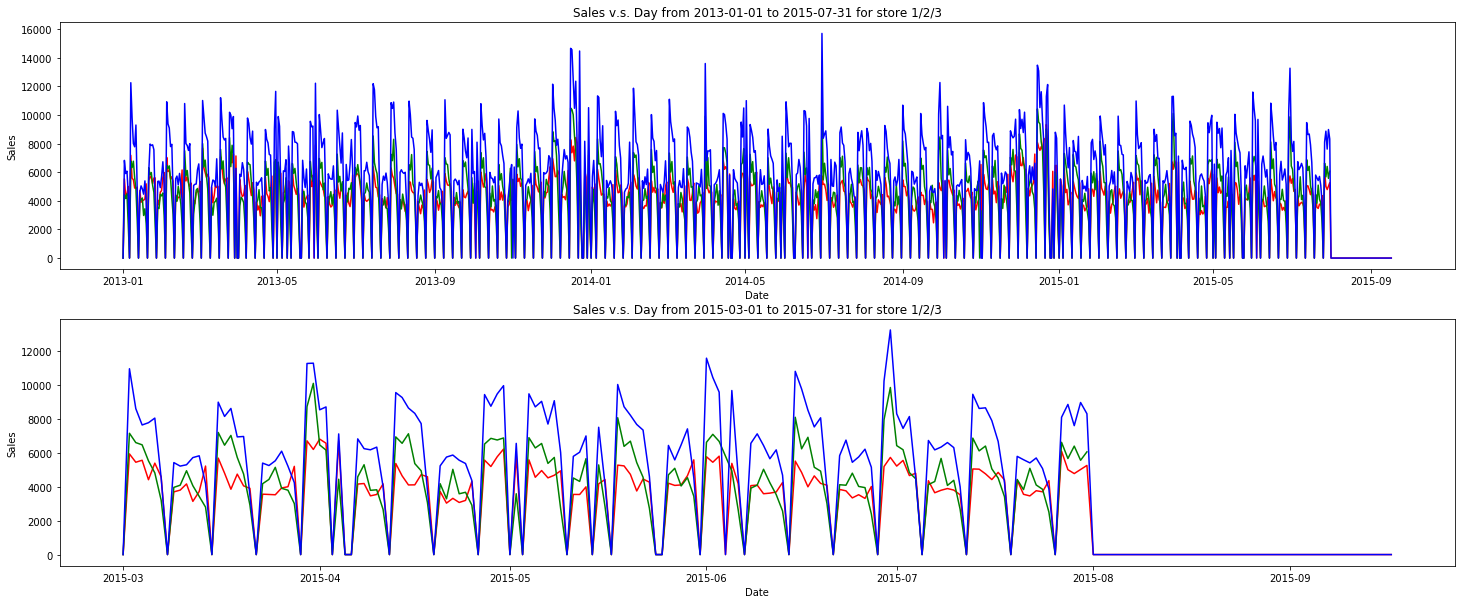

In [29]:
# 以1-3号店为例，查看其日销售额变化线图
df_store_1 = df[df['Store']==1]
df_store_2 = df[df['Store']==2]
df_store_3 = df[df['Store']==3]

fig,(ax1,ax2)= plt.subplots(2,1,figsize=(25,10))
## 绘制Store1从2013-01-01至2015-07-31日均销售额线图
ax1.plot(df_store_1['Date'],df_store_1['Sales'],'r')
## 绘制Store2从2013-01-01至2015-07-31日均销售额线图
ax1.plot(df_store_2['Date'],df_store_2['Sales'],'g')
## 绘制Store3从2013-01-01至2015-07-31日均销售额线图
ax1.plot(df_store_3['Date'],df_store_3['Sales'],'b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.set_title('Sales v.s. Day from 2013-01-01 to 2015-07-31 for store 1/2/3')

## 绘制Store1从2015-03-01至2015-07-31日均销售额线图
ax2.plot(df_store_1[df_store_1['Date']>='2015-03-01']['Date'],df_store_1[df_store_1['Date']>='2015-03-01']['Sales'],'r')
## 绘制Store2从2015-03-01至2015-07-31日均销售额线图
ax2.plot(df_store_2[df_store_2['Date']>='2015-03-01']['Date'],df_store_2[df_store_2['Date']>='2015-03-01']['Sales'],'g')
## 绘制Store3从2015-03-01至2015-07-31日均销售额线图
ax2.plot(df_store_3[df_store_3['Date']>='2015-03-01']['Date'],df_store_3[df_store_3['Date']>='2015-03-01']['Sales'],'b')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
ax2.set_title('Sales v.s. Day from 2015-03-01 to 2015-07-31 for store 1/2/3');

结论1.1:总体销售额均值呈周期性变化，其中按周和年的周期性较强，而按季度和月周期性相对不明显；以1-3号店铺为例，日销售额的周期性同上。通过上面的分析可知，一年当中不同时间粒度对销售额均有影响，所以考虑从此点出发，尝试利用观察时间衍生出其它时间特征，例如年（Year）、月（MonthOfYear）、日（DayOfYear，MonthOfDay）、周（WeekOfYear）等。

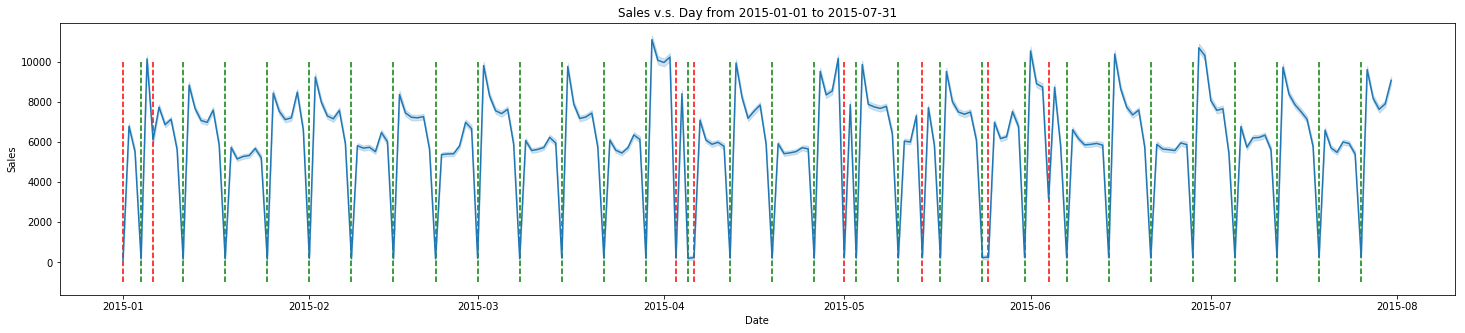

In [30]:
# 以2015年之后数据为例，研究周末和全国假期对销量的影响
df_2015 = df[(df['Date'] >= '2015-01-01') & (df['Date'] <= '2015-07-31')]
## 周末
weekends_2015 = df_2015.loc[df_2015['DayOfWeek']==7,'Date'].unique()
## 全国假期
stateholiday_2015 = df_2015.loc[df_2015['StateHoliday']!='0','Date'].unique()
##  
fig = plt.figure(figsize=(25,5))
sns.lineplot('Date','Sales',data=df_2015)
plt.title('Sales v.s. Day from 2015-01-01 to 2015-07-31')
plt.vlines(weekends_2015,-1000,10000,linestyles='dashed',colors='green',label='weekend')
plt.vlines(stateholiday_2015,-1000,10000,linestyles='dashed',colors='red',label='stateholiday');

上图中绿色和红色虚线分别表示周末及全国假期所处时间线，可以发现在这些时间点销量大多处于峰谷或较小值，观察时间接近这些时间点时销量通常不高，所以我们可以尝试构建时间间隔变量，即计算观察时间距离其最近的周末和（或）全国假期的时间差（天数）。

2.单变量分析：

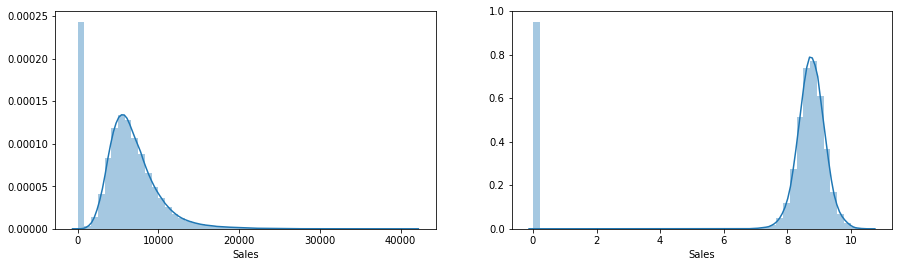

In [31]:
# 绘制销量额(Sales)直方图
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))

## ‘Sales’不做任何形式转换
sns.distplot(df[df['Sales'].notnull()]['Sales'],ax=ax1)
# ‘Sales’做log转换
sns.distplot(np.log1p(df['Sales']),ax=ax2);

结论2.1:‘Sales’不做任何形式转换时的直方图存在‘右拖尾’现象，考虑到一些较大的异常值会影响数据平稳性，所以尝试将该变量做log转换，取对数之后不会改变数据的性质和相关关系，但压缩了变量的尺度，使数据更加平稳，也消弱了模型的共线性、异方差性等（https://blog.csdn.net/anshuai_aw1/article/details/83866105）
可以发现‘Sales’做log转换后，其分布更接近正态分布且数据更平稳。上述两个直方图均存在销售额为0的情况，后期建模时可以只考虑销售额大于0的样本。

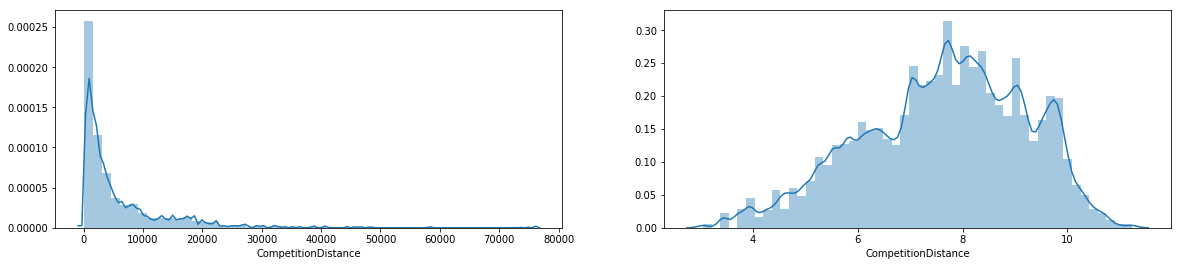

In [32]:
# 最近竞争店铺距离（CompetitionDistance）直方图
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,4))
sns.distplot(df[df['CompetitionDistance'].notnull()]['CompetitionDistance'],ax=ax1)
sns.distplot(np.log1p(df['CompetitionDistance']),ax=ax2);

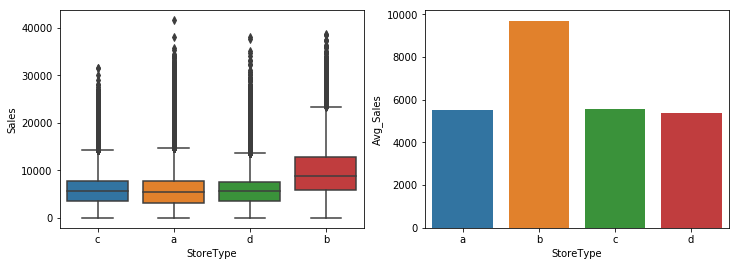

In [33]:
# 店铺类型(StoreType)对销售额的影响
store_type = df.groupby('StoreType')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(df['StoreType'],df['Sales'],ax=ax0)
sns.barplot(store_type['StoreType'],store_type['Avg_Sales'],ax=ax1);

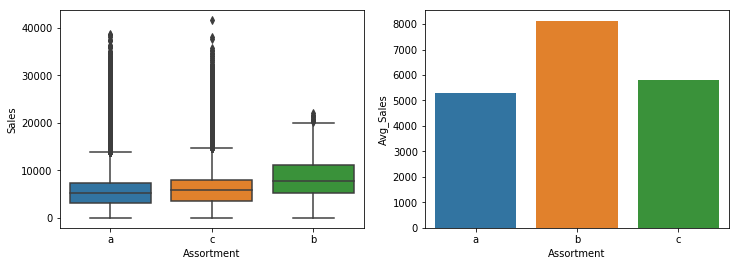

In [34]:
# 店铺分类等级（Assortment）对销售额的影响
assortment = df.groupby('Assortment')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(df['Assortment'],df['Sales'],ax=ax0)
sns.barplot(assortment['Assortment'],assortment['Avg_Sales'],ax=ax1);

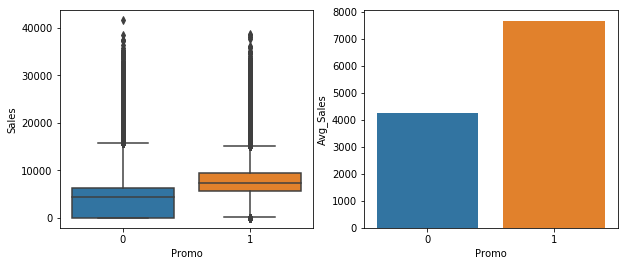

In [35]:
# 促销（Promo）对销售额的影响
promo = df.groupby('Promo')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
sns.boxplot(df['Promo'],df['Sales'],ax=ax0)
sns.barplot(promo['Promo'],promo['Avg_Sales'],ax=ax1);

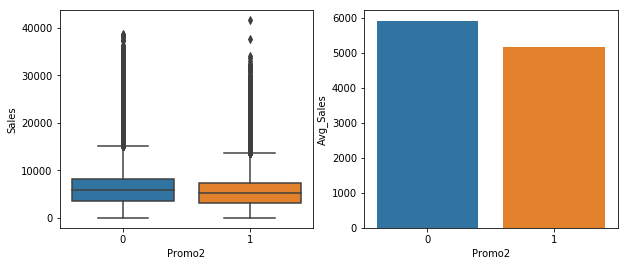

In [36]:
# 连续促销（Promo2）对销售额的影响
promo = df.groupby('Promo2')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
sns.boxplot(df['Promo2'],df['Sales'],ax=ax0)
sns.barplot(promo['Promo2'],promo['Avg_Sales'],ax=ax1);

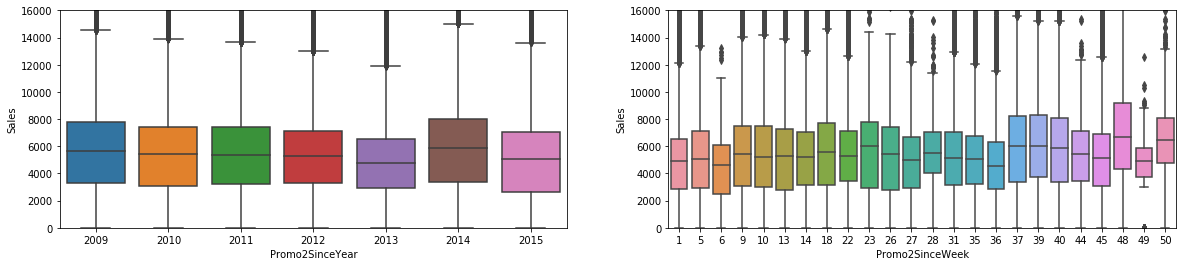

In [37]:
# 连续促销开始年份（Promo2SinceYear）、周（Promo2SinceWeek）对销售额的影响(箱线图)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(20,4))
sns.boxplot('Promo2SinceYear','Sales',data = df[df['Promo2SinceYear']!=0],ax=ax0)
sns.boxplot('Promo2SinceWeek','Sales',data = df[df['Promo2SinceWeek']!=0],ax=ax1)
ax0.set_ylim(0,16000)
ax1.set_ylim(0,16000);

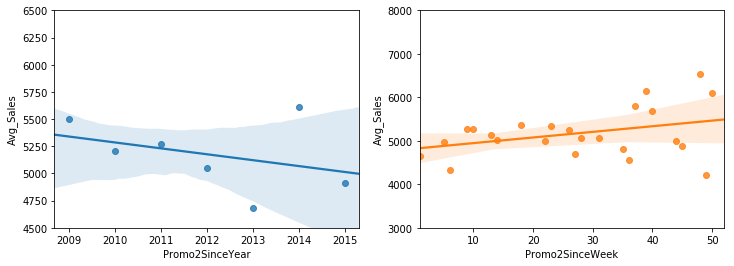

In [38]:
# 连续促销开始年份（Promo2SinceYear）、周（Promo2SinceWeek）对销售额的影响（聚合均值线图）
promo2_y = df.groupby('Promo2SinceYear')['Sales'].agg([('Avg_Sales','mean')]).reset_index()
promo2_w = df.groupby('Promo2SinceWeek')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
sns.regplot('Promo2SinceYear','Avg_Sales',data=promo2_y[promo2_y['Promo2SinceYear']!=0],ax=ax0)
sns.regplot('Promo2SinceWeek','Avg_Sales',data=promo2_w[promo2_w['Promo2SinceWeek']!=0],ax=ax1)

ax0.set_ylim(4500,6500)
ax1.set_xlim(1,52)
ax1.set_ylim(3000,8000);

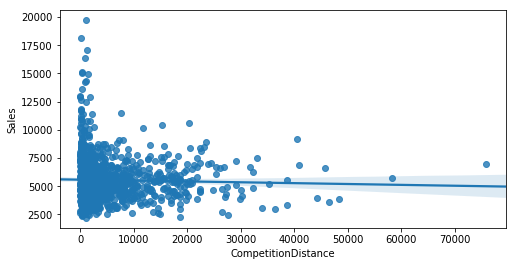

In [39]:
# 最近竞争店铺距离(CompetitionDistance)对销售额的影响
fig = plt.figure(figsize=(8,4))
competition_d = df.groupby('Store').agg({'CompetitionDistance':'mean','Sales':'mean'})
sns.regplot(competition_d['CompetitionDistance'],competition_d['Sales']);

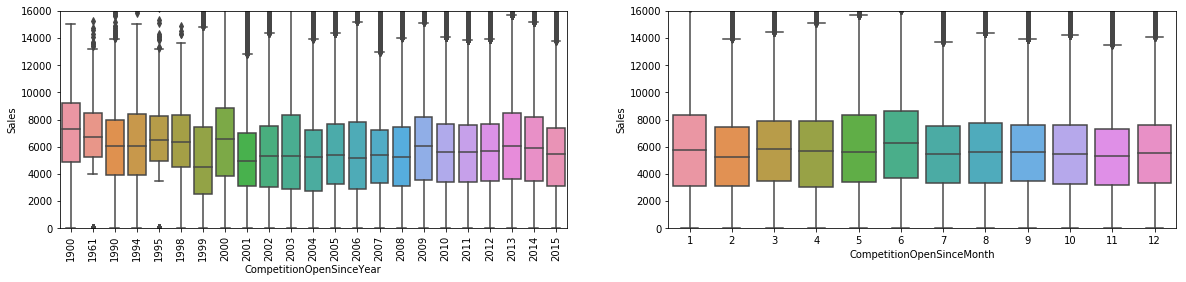

In [40]:
# 最近竞争店铺开始年份（CompetitionOpenSinceYear）、月份（CompetitionOpenSinceMonth）对销售额的影响(箱线图)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(20,4))
sns.boxplot('CompetitionOpenSinceYear','Sales',data = df,ax=ax0)
sns.boxplot('CompetitionOpenSinceMonth','Sales',data = df,ax=ax1)
ax0.set_ylim(0,16000)
ax0.set_xticklabels(labels=df['CompetitionOpenSinceYear'].sort_values().unique(),rotation=90)
ax1.set_ylim(0,16000);

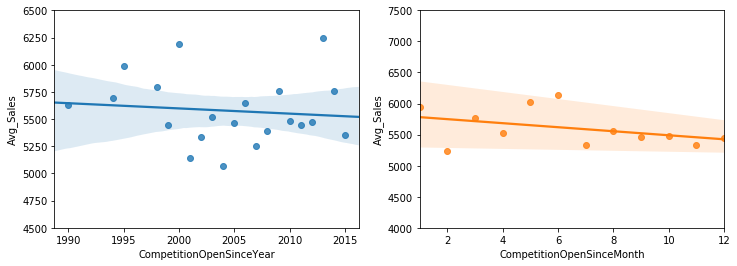

In [41]:
# 最近竞争店铺开始年份（CompetitionOpenSinceYear）、月份（CompetitionOpenSinceMonth）对销售额的影响（聚合均值线图）
competition_y = df.groupby('CompetitionOpenSinceYear')['Sales'].agg([('Avg_Sales','mean')]).reset_index()
competition_m = df.groupby('CompetitionOpenSinceMonth')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
sns.regplot('CompetitionOpenSinceYear','Avg_Sales',data=competition_y[competition_y['CompetitionOpenSinceYear']>=1990],ax=ax0)
sns.regplot('CompetitionOpenSinceMonth','Avg_Sales',data=competition_m,ax=ax1)
ax0.set_ylim(4500,6500)
ax1.set_xlim(1,12)
ax1.set_ylim(4000,7500);

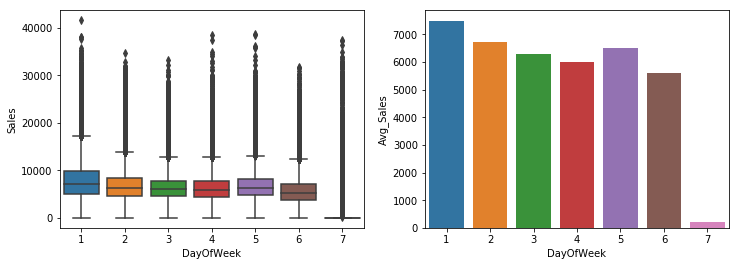

In [42]:
# 周（DayOfWeek）对销售额的影响
day_of_week = df.groupby('DayOfWeek')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(df['DayOfWeek'],df['Sales'],ax=ax0)
sns.barplot('DayOfWeek','Avg_Sales',data=day_of_week,ax=ax1);

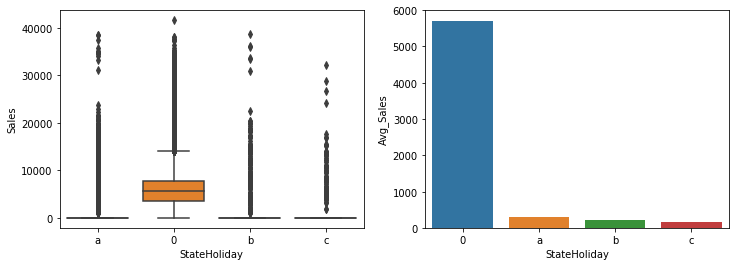

In [43]:
# 国家法定假期（StateHoliday）对销售额的影响
state_holiday = df.groupby('StateHoliday')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(df['StateHoliday'],df['Sales'],ax=ax0)
sns.barplot('StateHoliday','Avg_Sales',data=state_holiday,ax=ax1);

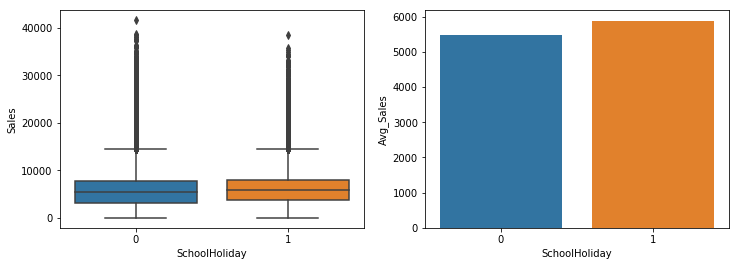

In [44]:
# 学校假期因素（SchoolHoliday）对销售额的影响
school_holiday = df.groupby('SchoolHoliday')['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(df['SchoolHoliday'],df['Sales'],ax=ax0)
sns.barplot('SchoolHoliday','Avg_Sales',data=school_holiday,ax=ax1);

结论2:a.考虑将'Sales' 和'CompetitionDistance'经过log转换后用于建模；b.就单变量分析结果而言，对销售额影响较强的因素包括促销因素（Promo，Promo2)，促销时间(DayOfWeek)、假期因素（StateHoliday，SchoolHoliday），店铺因素（StoreType,Assortment），最近竞争连锁店因素（CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceWeek）,这些都可以作为模型特征。

3.双变量分析：

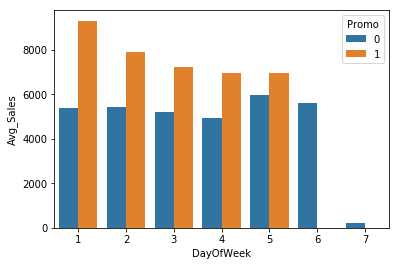

In [45]:
# DayOfWeek和Promo对销售额的影响
dayofweek_promo = df.groupby(['DayOfWeek','Promo'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

sns.barplot('DayOfWeek','Avg_Sales',hue='Promo',data=dayofweek_promo)
plt.legend(loc='upper right',title='Promo');

促销只在周一到周五开展，周六和周日无促销活动。周一到周六在非促销情况下所有店的平均销售额差别不大（周五和周六略高），周日大部门连锁店不营业，销售额最低。促销在某种程度上增加了营业额，促销的增额效果从周一至周五逐渐减弱，表现为在促销情况下周一到周五所有店的平均销售额逐渐下降。

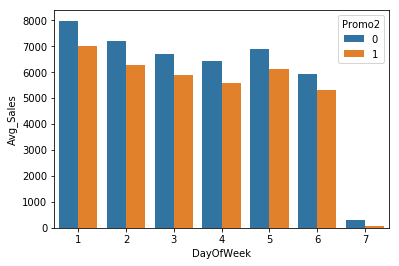

In [46]:
# DayOfWeek和Promo2对销售额的影响
dayofweek_promo2 = df.groupby(['DayOfWeek','Promo2'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

sns.barplot('DayOfWeek','Avg_Sales',hue='Promo2',data=dayofweek_promo2)
plt.legend(loc='upper right',title='Promo2');

从周一至周日，无论参与或未参与长期促销的连锁店均有营业，且平均营业额均逐渐降低（周五稍有例外），同时未参与长期促销的连锁店平均营业额略高于参与长期促销的连锁店。

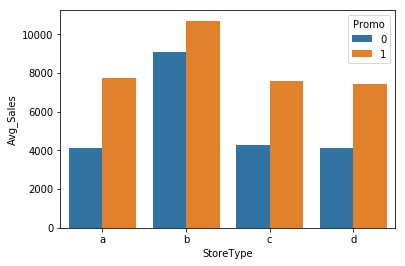

In [47]:
# StoreType和Promo对销售额的影响
storetype_promo = df.groupby(['StoreType','Promo'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

sns.barplot('StoreType','Avg_Sales',hue='Promo',data=storetype_promo)
plt.legend(loc='upper right',title='Promo');

无论促销与否，b类连锁店的营业额总体上高于其它类型的连锁店；但是b类连锁店由促销带动营业额增加的效果远远不及其它类型连锁店。a、c和d类店铺促销活动总体上会带来营业额的翻倍，但是b类连锁店营业额增加幅度不到1/4。

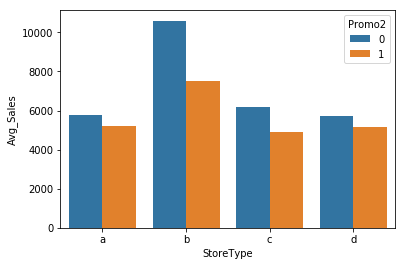

In [48]:
# StoreType和Promo2对销售额的影响
storetype_promo = df.groupby(['StoreType','Promo2'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

sns.barplot('StoreType','Avg_Sales',hue='Promo2',data=storetype_promo)
plt.legend(loc='upper right',title='Promo2');

无论是否参与长期促销活动，b类连锁店的营业额总体上高于其它类型的连锁店；但是长期促销店铺的平均销售额均低于未参加长期促销的店铺，尤其对于b类店铺而言，参与长期促销导致的平均营业额下降幅度高于其它店铺类型。

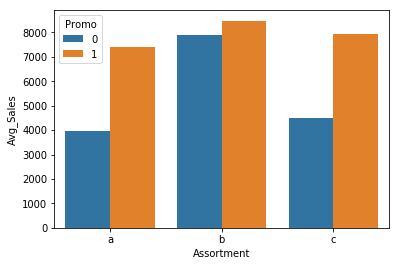

In [49]:
# Assortment和Promo对销售额的影响
storetype_promo = df.groupby(['Assortment','Promo'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

sns.barplot('Assortment','Avg_Sales',hue='Promo',data=storetype_promo)
plt.legend(loc='upper left',title='Promo');

无论促销与否，b等级连锁店的营业额总体上高于其它等级的连锁店；但是b等级连锁店由促销带动营业额增加的效果远远不及其它等级连锁店。a和c等级店铺促销活动总体上会带来营业额的翻倍，但是b等级连锁店营业额增加幅度较低。

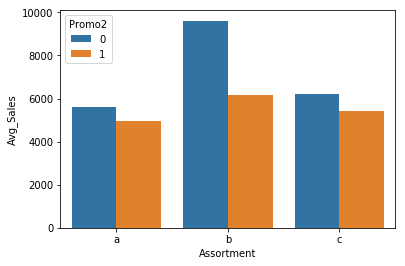

In [50]:
# Assortment和Promo2对销售额的影响
storetype_promo = df.groupby(['Assortment','Promo2'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

sns.barplot('Assortment','Avg_Sales',hue='Promo2',data=storetype_promo)
plt.legend(loc='upper left',title='Promo2');

无论是否参与长期促销活动，b等级连锁店的营业额总体上高于其它等级的连锁店；但是长期促销店铺的平均销售额均低于未参加长期促销的店铺，尤其对于b等级店铺而言，参与长期促销导致的平均营业额下降幅度高于其它等级的店铺。

/Users/zhanglijuan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


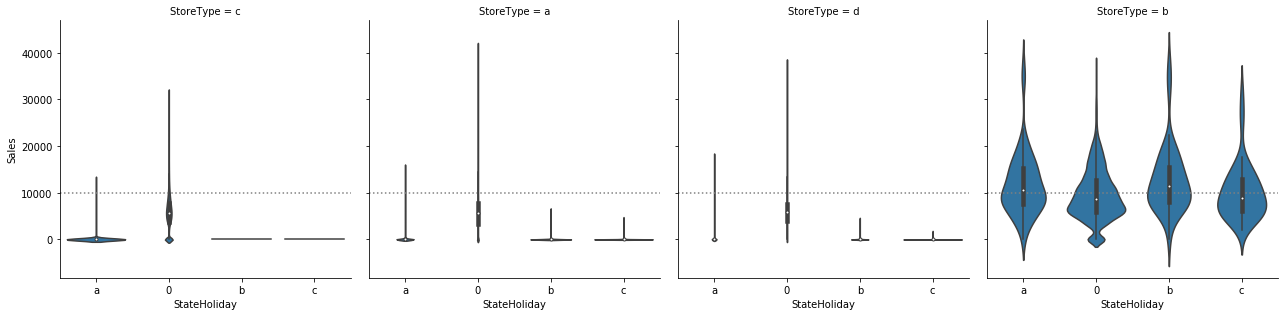

In [51]:
# StoreType和StateHoliday对销售额的影响

grid = sns.FacetGrid(df, col="StoreType", palette="tab20c",col_wrap=4, height=4.5)
# 绘制销售额是10000的水平线
grid.map(plt.axhline, y=10000, ls=":", c=".5")
grid.map(sns.violinplot, "StateHoliday", "Sales");

a、c和d类连锁店在全国假期期间销售额相对b类较少。对于b类连锁店，在假期的销售额几乎均高于非假期，例如 Easter holiday(b)销售额 > public holiday(a)销售额 > Christmas(c)销售额。可以推测，b类连锁店在假期营业的销售额是其营业额的重要组成部分，这也可以部分解释为什么b类连锁店平均销售额高于其它类型店铺。

/Users/zhanglijuan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


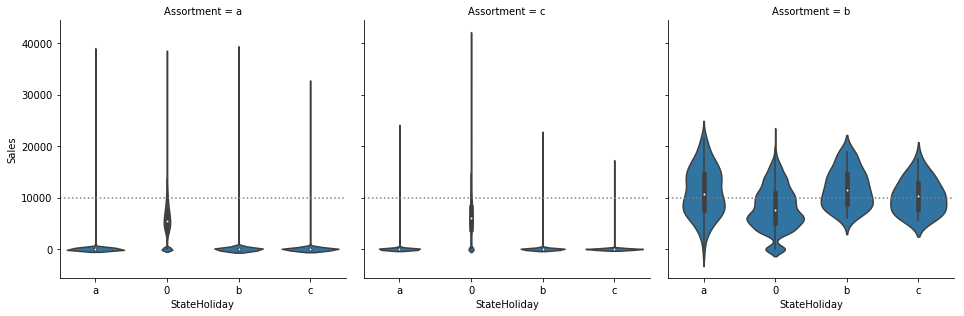

In [52]:
# Assortment和StateHoliday对销售额的影响

grid = sns.FacetGrid(df, col="Assortment", palette="tab20c",col_wrap=3, height=4.5)
# 绘制销售额是10000的水平线
grid.map(plt.axhline, y=10000, ls=":", c=".5")
grid.map(sns.violinplot, "StateHoliday", "Sales");

a和c等级连锁店在全国假期期间销售额相对b等级较少。对于b等级连锁店，在假期的整体销售额几乎均高于非假期，例如 Easter holiday(b)销售额 > public holiday(a)销售额 > Christmas(c)销售额。可以推测，b等级连锁店在假期营业的销售额是其营业额的重要组成部分，这也可以部分解释为什么b等级连锁店平均销售额高于其它等级店铺。

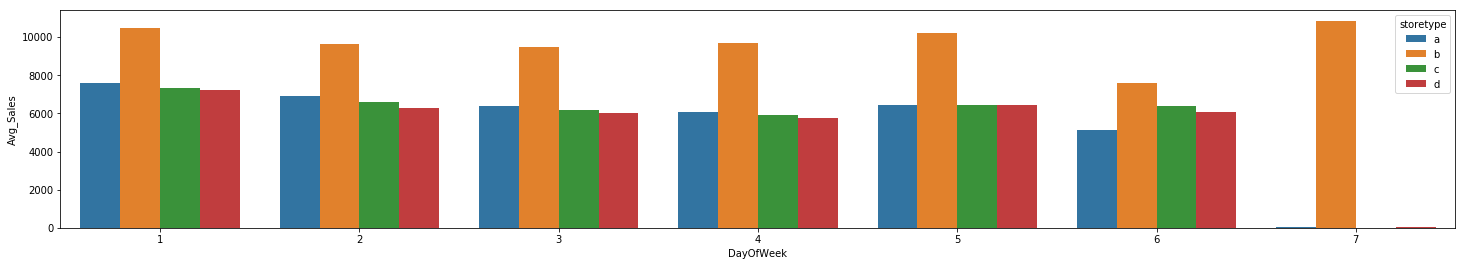

In [53]:
# DayOfWeek和StoreType对销售额的影响
dayofweek_storetype = df.groupby(['DayOfWeek','StoreType'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig = plt.figure(figsize=(25,4))
sns.barplot('DayOfWeek','Avg_Sales',hue='StoreType',data=dayofweek_storetype)
plt.legend(loc='upper right',title='storetype');

周一到周六b类连锁店平均销售额最高，其它类连锁店平均销售额差距不大，但都大于b类销售额的一半。对于b类连锁店而言，周日平均销售额是一周中最高的，而其它类连锁店平均销售几乎可以忽略不计。可以推测，b类连锁店在周日营业的销售额是其营业额的重要组成部分，这也可以部分解释为什么b类连锁店平均销售额高于其它类型店铺。

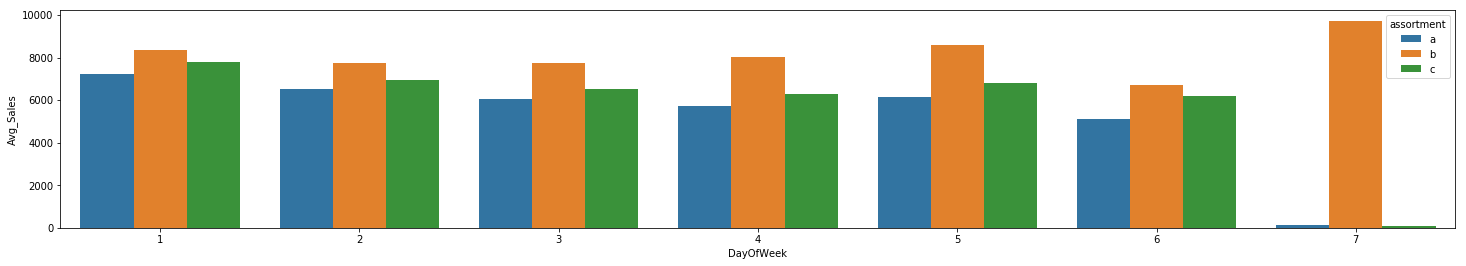

In [54]:
# DayOfWeek和Assortment对销售额的影响
dayofweek_storetype = df.groupby(['DayOfWeek','Assortment'])['Sales'].agg([('Avg_Sales','mean')]).reset_index()

fig = plt.figure(figsize=(25,4))
sns.barplot('DayOfWeek','Avg_Sales',hue='Assortment',data=dayofweek_storetype)
plt.legend(loc='upper right',title='assortment');

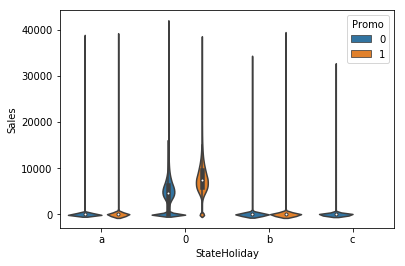

In [55]:
# Promo和StateHoliday对销售额的影响

sns.violinplot('StateHoliday','Sales',hue='Promo',data=df);

圣诞节(c)无促销活动。促销活动对全国假期期间的销售额几乎无影响，但是促销活动可以促进非假期期间的销售额。

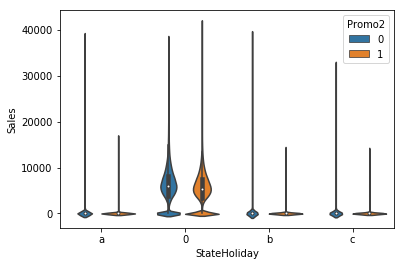

In [56]:
# Promo2和StateHoliday对销售额的影响

sns.violinplot('StateHoliday','Sales',hue='Promo2',data=df);

长期促销活动存在于全国假期和非假期，但是对销售额没有很大影响。

4.多变量分析：

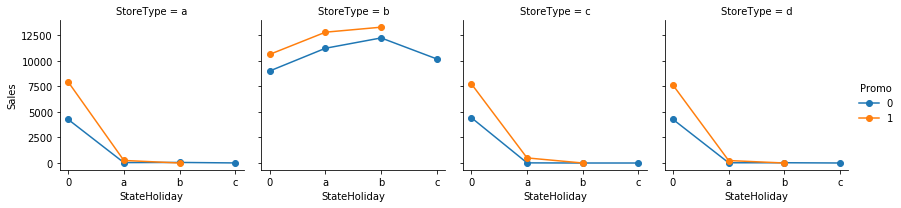

In [57]:
# StoreType、StateHoliday、Promo对销售额的影响

storetype_stateholiday_promo = df.groupby(['StoreType','StateHoliday','Promo']).agg({'Sales':'mean'}).reset_index()

mpl.rcParams['agg.path.chunksize'] = 10000
grid = sns.FacetGrid(storetype_stateholiday_promo, col="StoreType", hue="Promo")
grid.map(plt.plot, "StateHoliday", "Sales", marker="o").add_legend();

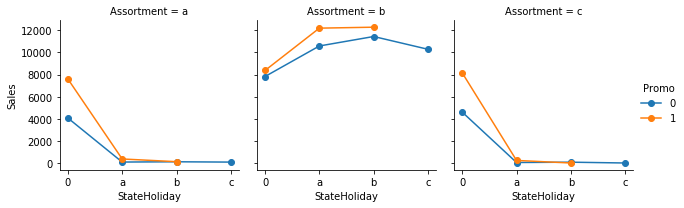

In [58]:
# Assortment、StateHoliday、Promo对销售额的影响

assortment_stateholiday_promo = df.groupby(['Assortment','StateHoliday','Promo']).agg({'Sales':'mean'}).reset_index()

mpl.rcParams['agg.path.chunksize'] = 10000
grid = sns.FacetGrid(assortment_stateholiday_promo, col="Assortment", hue="Promo")
grid.map(plt.plot, "StateHoliday", "Sales", marker="o").add_legend();

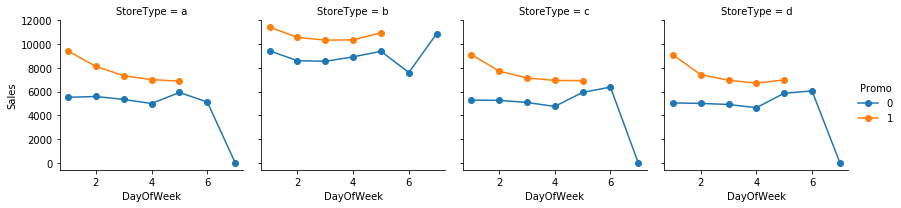

In [59]:
# StoreType、DayOfWeek、Promo对销售额的影响

storetype_dayofweek_promo = df.groupby(['StoreType','DayOfWeek','Promo']).agg({'Sales':'mean'}).reset_index()

mpl.rcParams['agg.path.chunksize'] = 10000
grid = sns.FacetGrid(storetype_dayofweek_promo, col="StoreType", hue="Promo")
grid.map(plt.plot, "DayOfWeek", "Sales", marker="o").add_legend();

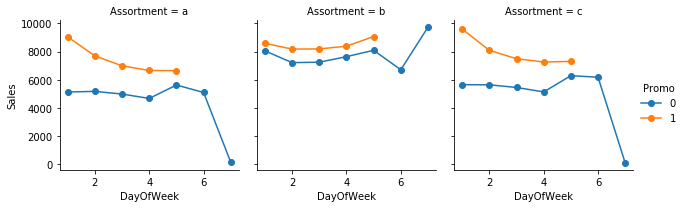

In [60]:
# Assortment、DayOfWeek、Promo对销售额的影响

assortment_dayofweek_promo = df.groupby(['Assortment','DayOfWeek','Promo']).agg({'Sales':'mean'}).reset_index()

mpl.rcParams['agg.path.chunksize'] = 10000
grid = sns.FacetGrid(assortment_dayofweek_promo, col="Assortment", hue="Promo")
grid.map(plt.plot, "DayOfWeek", "Sales", marker="o").add_legend();

第三步：根据变量探索结果构造新特征

In [61]:
# 时间特征

## 年 
df['Year'] = df['Date'].dt.year
## 月
df['MonthOfYear'] = df['Date'].dt.month
## 周
df['WeekOfYear'] = df['Date'].dt.week
## 日
df['DayOfMonth'] = df['Date'].dt.day
##  日
df['DayOfYear'] = [int(t.strftime('%j')) for t in df['Date']]

In [62]:
# 观察日期距离最近全国假期的时间间隔

state_holiday_date = df.loc[df['StateHoliday']!='0','Date'].unique()

df_interval_1 = df.copy()
for i,date in enumerate(state_holiday_date):
    df_interval_1[i] = df_interval_1['Date'] - date
   
df['StateHoliday_DayDiff'] = df_interval_1[[i for i in range(state_holiday_date.size)]].apply(lambda x: np.abs(x.dt.days)).apply(lambda x: min(x), axis=1)

In [63]:
# 观察日期距离最近周末时间间隔

weekends_date = df.loc[df['DayOfWeek']==7,'Date'].unique()

df_interval_2 = df.copy()
for i,date in enumerate(weekends_date):
    df_interval_2[i] = df_interval_2['Date'] - date
   
df['Weekends_DayDiff'] = df_interval_2[[i for i in range(weekends_date.size)]].apply(lambda x: np.abs(x.dt.days)).apply(lambda x: min(x), axis=1)

In [64]:
# 观察日期距离最近周末或全国假期的时间间隔

weekends = df.loc[df['DayOfWeek']==7,'Date'].unique()
stateholiday = df.loc[df['StateHoliday']!='0','Date'].unique()
weekends_stateholiday = np.append(weekends,stateholiday)

df_interval_3 = df.copy()
for i,date in enumerate(weekends_stateholiday):
    df_interval_3[i] = df_interval_3['Date'] - date
    
df['Weekends_StateHoliday_DayDiff'] = df_interval_3[[i for i in range(weekends_stateholiday.size)]].apply(lambda x: np.abs(x.dt.days)).apply(lambda x: min(x), axis=1)

In [65]:
# 最近竞争店铺距离观察时间的已开业月份数

df['Competition_month_num'] = 12*(df['Date'].dt.year-df['CompetitionOpenSinceYear'])+df['Date'].dt.month-df['CompetitionOpenSinceMonth']

In [66]:
# 连锁店开始参与长期促销的周数

df['Promo2_week_num'] = 52*(df['Date'].dt.year-df['Promo2SinceYear'])+df['Date'].dt.week-df['Promo2SinceWeek']
## 在观察时间之后参与长期促销的连锁店该特征为0
df.loc[df['Promo2_week_num']< 0,'Promo2_week_num'] = 0
## 未参与长期促销的连锁店该特征为0
df.loc[df['Promo2SinceYear']==0,'Promo2_week_num'] = 0

第四步：数据预处理

In [67]:
# 类别变量数值化

## Assortment
df['Assortment_level'] = df['Assortment'].map({'a':1,'b':2,'c':3})

## PromoInterval
df['PromoInterval_level'] = df['PromoInterval'].map({'0':0,'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3})

## StateHoliday
df['StateHoliday_level'] = df['StateHoliday'].map({'0':1,'a':2,'b':3,'c':4})

## StoreType
df['StoreType_level'] = df['StoreType'].map({'a':1,'b':2,'c':3,'d':4})

## State
df['State_level'] = df['State'].map({'BE':1,
                                     'BW':2,
                                     'BY':3,
                                     'HB,NI':4,
                                     'HE':5,
                                     'HH':6,
                                     'NW':7,
                                     'RP':8,
                                     'SH':9,
                                     'SN':10,
                                     'ST':11,
                                     'TH':12})

# 特征CompetitionDistance取对数
df['CompetitionDistance'] = np.log1p(df['CompetitionDistance'])

In [68]:
# 删除不用于建模的特征
df.drop(['Customers','Id','Assortment','PromoInterval','StateHoliday','StoreType','State'],axis=1,inplace=True)

第五步：划分训练集、验证集和测试集

In [69]:
# 建模时只采用营业店铺且销售额大于0的样本

## 训练集选取2015-06-14之前样本
train = df[df.Date < '2015-06-14']
X_train = train[(train['Open']==1) & (train['Sales']>0)].drop(['Date','Sales'],axis=1)
y_train = np.log1p(train[(train['Open']==1) & (train['Sales']>0)]['Sales'])

## 验证集选取2015-06-14至2015-07-31期间样本 
valid = df[(df.Date > '2015-06-13') & (df.Date < '2015-08-01')]
X_valid = valid[(valid['Open']==1) & (valid['Sales'] >0)].drop(['Date','Sales'],axis=1)
y_valid = np.log1p(valid[(valid['Open']==1) & (valid['Sales'] >0)]['Sales'])

## 测试集选取2015-08-01之后样本
test = df[df.Date > '2015-07-31'].sort_values(by=['Date','Store'],ascending=[0,1])
X_test = test[test['Open']==1].drop(['Date','Sales'],axis=1)

第六步：特征筛选

In [70]:
# 建立随机森林回归模型

rf_model = RandomForestRegressor(max_depth=10,random_state=0)
rf_model.fit(X_train,y_train)

/Users/zhanglijuan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [71]:
# 特征重要性
fea_imp = pd.DataFrame(rf_model.feature_importances_,
                       columns=['feature_importance'],
                       index=X_train.columns).sort_values(by='feature_importance',ascending=False)

# 选取重要性大于0.001的特征
fea_imp = fea_imp[fea_imp['feature_importance']>1e-03]
fea_imp

,feature_importance
Promo,0.318976
CompetitionDistance,0.114350
State_level,0.091170
Store,0.083367
Promo2SinceYear,0.050794
Weekends_StateHoliday_DayDiff,0.040974
Assortment_level,0.038895
CompetitionOpenSinceMonth,0.037852
StoreType_level,0.033947
DayOfWeek,0.033844


In [72]:
# 去除相关性高的特征函数
def rm_features_high_corr(df, cols, threshold = .7):
    """
    df:数据集
    cols:待检验相关性的变量列表
    threshold:相关性阈值
    
    return:
    ret:筛选出的变量
    """

    df_corr = df[cols].corr(method='spearman')

    df_corr_drops = df_corr.apply(
        lambda r:[df_corr.index[i] for i, v in enumerate(r) if v > threshold])

    ret = []
    drop_cols = []
    fs = cols

    for e in iter(fs):

        if e in drop_cols:
            continue 
        ret.append(e)
        for e_v in df_corr_drops[e][1:]:
            if(e_v not in drop_cols):
                drop_cols.append(e_v)

    return ret

In [73]:
# 最终特征集
features = rm_features_high_corr(df, list(fea_imp.index), threshold = .7)
features

['Promo',
 'CompetitionDistance',
 'State_level',
 'Store',
 'Promo2SinceYear',
 'Weekends_StateHoliday_DayDiff',
 'Assortment_level',
 'CompetitionOpenSinceMonth',
 'StoreType_level',
 'DayOfWeek',
 'CompetitionOpenSinceYear',
 'DayOfYear',
 'Promo2_week_num',
 'StateHoliday_DayDiff',
 'Competition_month_num',
 'SchoolHoliday',
 'DayOfMonth']

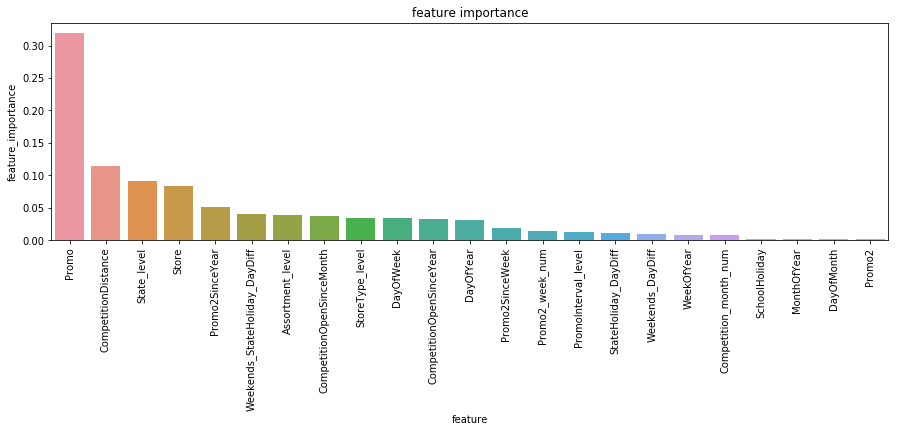

In [74]:
# 可视化最终特征集
fig = plt.figure(figsize=(15,4))
sns.barplot(fea_imp.index,fea_imp['feature_importance'])
plt.title('feature importance')
plt.xlabel('feature')
plt.ylabel('feature_importance')
plt.xticks(np.arange(len(fea_imp.index)),fea_imp.index,rotation=90);

第七步：建立基准RFR模型，并在训练集和验证集上评估模型效果（rmspe）

In [75]:
# 定义随机森林回归模型评估函数
def rmspe(y,y_pre):
    if y.any()!=0:   
        return np.sqrt(np.mean((1-y_pre/y)**2))
    else:
        pass 

In [76]:
# 建立随机森林回归模型（RFR模型）
#rf_model = RandomForestRegressor(max_depth=10,random_state=0)
# 训练RFR模型
rf_model.fit(X_train[features],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [77]:
# RFR模型预测训练集
rf_y_train_pre = rf_model.predict(X_train[features])
# 评估RFR在训练集上的性能
rmspe(np.expm1(y_train.values),np.expm1(rf_y_train_pre))

0.33663547040245206

In [78]:
# RFR模型预测验证集
rf_y_valid_pre = rf_model.predict(X_valid[features])
# 评估RFR在验证集上的性能
rmspe(np.expm1(y_valid.values),np.expm1(rf_y_valid_pre))

0.285396938132885

In [79]:
# RFR模型预测测试集——>0.30866
rf_y_test_pre = rf_model.predict(X_test[features])

In [80]:
# 测试集中不同店铺每天的实际和预测日销售额
rf_test_pre_sales = pd.Series(np.expm1(rf_y_test_pre),index=X_test.index,name='PreSales')
rf_test = test[['Date','Store','Open']].join(rf_test_pre_sales,how='left')
# 未开门的店铺销量为0
rf_test.loc[rf_test['Open']==0,'PreSales'] = 0

In [81]:
# 创建提交文件rf_sub
rf_sub_1 = pd.read_csv('sample_submission.csv')
rf_sub_2 = rf_test[['Store','Date','PreSales']].reset_index().drop(['index'],axis=1)
rf_sub = pd.concat([rf_sub_1,rf_sub_2],axis=1)[['Id','PreSales']]
rf_sub.rename(columns={'PreSales':'Sales'},inplace=True)

In [82]:
# 将提交文件保存为csv
rf_sub.to_csv('rf_submission.csv',index=False)

第八步：建立XGBoost模型，并在训练集和验证集上评估模型效果（rmspe）

In [83]:
# XGBoost模型自定义评估函数
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [84]:
# 建立XGBoost模型

## XGBoost模型参数
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.06,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          'verbosity':1,
          "seed": 10
          }

dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]


## 模型训练开始时间
start = time.time()

## 模型训练参数
model_xgboost = xgb.train(
    params,
    dtrain,
    num_boost_round= 1000,
    evals = watchlist,
    feval= rmspe_xg,
    early_stopping_rounds=100,
    verbose_eval=1)

## 模型训练结束时间
end = time.time()
print('Training time is {:2f} s.'.format(end-start))

/Users/zhanglijuan/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:7.77174	eval-rmse:7.80559	train-rmspe:0.999707	eval-rmspe:0.999719
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.30655	eval-rmse:7.34078	train-rmspe:0.999433	eval-rmspe:0.999455
[2]	train-rmse:6.86927	eval-rmse:6.90362	train-rmspe:0.999029	eval-rmspe:0.999068
[3]	train-rmse:6.45812	eval-rmse:6.49244	train-rmspe:0.998455	eval-rmspe:0.998516
[4]	train-rmse:6.07176	eval-rmse:6.10632	train-rmspe:0.997651	eval-rmspe:0.997743
[5]	train-rmse:5.7085	eval-rmse:5.74309	train-rmspe:0.996558	eval-rmspe:0.996692
[6]	train-rmse:5.36706	eval-rmse:5.40127	train-rmspe:0.995102	eval-rmspe:0.995291
[7]	train-rmse:5.04635	eval-rmse:5.08264	train-rmspe:0.993196	eval-rmspe:0.993469
[8]	train-rmse:4.74478	eval-rmse:4.78106	train-rmspe:0.990761	eval-rmspe:0.99113
[9]	train-rmse:4.46133	eval-rmse:4.49868	train-rmspe:0.987704	eval-rmspe:0.988206
[10]	train-rmse:4.19487	eval-rmse:4.

[96]	train-rmse:0.179978	eval-rmse:0.198252	train-rmspe:0.217815	eval-rmspe:0.189463
[97]	train-rmse:0.179165	eval-rmse:0.197264	train-rmspe:0.213951	eval-rmspe:0.188886
[98]	train-rmse:0.177649	eval-rmse:0.195716	train-rmspe:0.212884	eval-rmspe:0.18788
[99]	train-rmse:0.175526	eval-rmse:0.193663	train-rmspe:0.211234	eval-rmspe:0.186021
[100]	train-rmse:0.174508	eval-rmse:0.192769	train-rmspe:0.210545	eval-rmspe:0.185399
[101]	train-rmse:0.17412	eval-rmse:0.192253	train-rmspe:0.210226	eval-rmspe:0.185224
[102]	train-rmse:0.172933	eval-rmse:0.191008	train-rmspe:0.208938	eval-rmspe:0.184206
[103]	train-rmse:0.172161	eval-rmse:0.190105	train-rmspe:0.208184	eval-rmspe:0.183641
[104]	train-rmse:0.170824	eval-rmse:0.188701	train-rmspe:0.207109	eval-rmspe:0.182238
[105]	train-rmse:0.170463	eval-rmse:0.188165	train-rmspe:0.206952	eval-rmspe:0.181986
[106]	train-rmse:0.17023	eval-rmse:0.187815	train-rmspe:0.205134	eval-rmspe:0.181811
[107]	train-rmse:0.168408	eval-rmse:0.185955	train-rmspe:0.20

[192]	train-rmse:0.12743	eval-rmse:0.149487	train-rmspe:0.150409	eval-rmspe:0.147243
[193]	train-rmse:0.127045	eval-rmse:0.14904	train-rmspe:0.150056	eval-rmspe:0.146838
[194]	train-rmse:0.126787	eval-rmse:0.14891	train-rmspe:0.149601	eval-rmspe:0.146657
[195]	train-rmse:0.126476	eval-rmse:0.148646	train-rmspe:0.14913	eval-rmspe:0.146426
[196]	train-rmse:0.126138	eval-rmse:0.148371	train-rmspe:0.148819	eval-rmspe:0.146155
[197]	train-rmse:0.125721	eval-rmse:0.14797	train-rmspe:0.148406	eval-rmspe:0.145711
[198]	train-rmse:0.12568	eval-rmse:0.147916	train-rmspe:0.14837	eval-rmspe:0.145667
[199]	train-rmse:0.125499	eval-rmse:0.147754	train-rmspe:0.148185	eval-rmspe:0.145483
[200]	train-rmse:0.125273	eval-rmse:0.14755	train-rmspe:0.147962	eval-rmspe:0.145292
[201]	train-rmse:0.12503	eval-rmse:0.14735	train-rmspe:0.147673	eval-rmspe:0.145086
[202]	train-rmse:0.124693	eval-rmse:0.147067	train-rmspe:0.147271	eval-rmspe:0.14483
[203]	train-rmse:0.123768	eval-rmse:0.146415	train-rmspe:0.146349

[288]	train-rmse:0.105613	eval-rmse:0.131855	train-rmspe:0.127595	eval-rmspe:0.130115
[289]	train-rmse:0.105431	eval-rmse:0.131754	train-rmspe:0.127422	eval-rmspe:0.129996
[290]	train-rmse:0.105279	eval-rmse:0.131644	train-rmspe:0.127285	eval-rmspe:0.129903
[291]	train-rmse:0.105021	eval-rmse:0.131424	train-rmspe:0.12704	eval-rmspe:0.129674
[292]	train-rmse:0.104855	eval-rmse:0.131277	train-rmspe:0.126879	eval-rmspe:0.129528
[293]	train-rmse:0.10473	eval-rmse:0.131148	train-rmspe:0.126771	eval-rmspe:0.129395
[294]	train-rmse:0.104502	eval-rmse:0.130906	train-rmspe:0.126559	eval-rmspe:0.129176
[295]	train-rmse:0.104366	eval-rmse:0.130819	train-rmspe:0.126432	eval-rmspe:0.129096
[296]	train-rmse:0.104092	eval-rmse:0.130592	train-rmspe:0.126183	eval-rmspe:0.128904
[297]	train-rmse:0.10407	eval-rmse:0.130587	train-rmspe:0.126149	eval-rmspe:0.128906
[298]	train-rmse:0.103877	eval-rmse:0.130439	train-rmspe:0.125953	eval-rmspe:0.128775
[299]	train-rmse:0.103712	eval-rmse:0.13032	train-rmspe:0

[384]	train-rmse:0.095483	eval-rmse:0.125395	train-rmspe:0.116932	eval-rmspe:0.12388
[385]	train-rmse:0.095459	eval-rmse:0.125392	train-rmspe:0.116903	eval-rmspe:0.123876
[386]	train-rmse:0.095418	eval-rmse:0.125356	train-rmspe:0.116862	eval-rmspe:0.123843
[387]	train-rmse:0.095338	eval-rmse:0.12532	train-rmspe:0.116791	eval-rmspe:0.123807
[388]	train-rmse:0.095246	eval-rmse:0.125261	train-rmspe:0.116701	eval-rmspe:0.123741
[389]	train-rmse:0.095198	eval-rmse:0.125314	train-rmspe:0.116654	eval-rmspe:0.123771
[390]	train-rmse:0.095096	eval-rmse:0.125251	train-rmspe:0.116548	eval-rmspe:0.123697
[391]	train-rmse:0.095014	eval-rmse:0.12519	train-rmspe:0.11647	eval-rmspe:0.123638
[392]	train-rmse:0.094987	eval-rmse:0.125151	train-rmspe:0.116446	eval-rmspe:0.123607
[393]	train-rmse:0.094927	eval-rmse:0.125104	train-rmspe:0.116391	eval-rmspe:0.123568
[394]	train-rmse:0.094819	eval-rmse:0.125036	train-rmspe:0.116288	eval-rmspe:0.123496
[395]	train-rmse:0.09477	eval-rmse:0.125006	train-rmspe:0.

[480]	train-rmse:0.089476	eval-rmse:0.122394	train-rmspe:0.110979	eval-rmspe:0.120961
[481]	train-rmse:0.08942	eval-rmse:0.122363	train-rmspe:0.110928	eval-rmspe:0.120925
[482]	train-rmse:0.089368	eval-rmse:0.122355	train-rmspe:0.110865	eval-rmspe:0.120916
[483]	train-rmse:0.089351	eval-rmse:0.122361	train-rmspe:0.110849	eval-rmspe:0.120917
[484]	train-rmse:0.089275	eval-rmse:0.122292	train-rmspe:0.110774	eval-rmspe:0.120857
[485]	train-rmse:0.089255	eval-rmse:0.122277	train-rmspe:0.110741	eval-rmspe:0.120844
[486]	train-rmse:0.089171	eval-rmse:0.122253	train-rmspe:0.110646	eval-rmspe:0.120825
[487]	train-rmse:0.089154	eval-rmse:0.122241	train-rmspe:0.110629	eval-rmspe:0.120813
[488]	train-rmse:0.089075	eval-rmse:0.1222	train-rmspe:0.110556	eval-rmspe:0.12078
[489]	train-rmse:0.088982	eval-rmse:0.122147	train-rmspe:0.110473	eval-rmspe:0.120725
[490]	train-rmse:0.088933	eval-rmse:0.122143	train-rmspe:0.11043	eval-rmspe:0.120731
[491]	train-rmse:0.088885	eval-rmse:0.122119	train-rmspe:0.

[576]	train-rmse:0.085098	eval-rmse:0.120388	train-rmspe:0.10631	eval-rmspe:0.119026
[577]	train-rmse:0.085034	eval-rmse:0.120412	train-rmspe:0.106233	eval-rmspe:0.119051
[578]	train-rmse:0.084989	eval-rmse:0.120388	train-rmspe:0.106181	eval-rmspe:0.119031
[579]	train-rmse:0.084944	eval-rmse:0.120368	train-rmspe:0.106139	eval-rmspe:0.119009
[580]	train-rmse:0.084885	eval-rmse:0.120339	train-rmspe:0.106086	eval-rmspe:0.118984
[581]	train-rmse:0.084869	eval-rmse:0.120336	train-rmspe:0.106073	eval-rmspe:0.118981
[582]	train-rmse:0.084791	eval-rmse:0.12029	train-rmspe:0.105999	eval-rmspe:0.118941
[583]	train-rmse:0.084744	eval-rmse:0.120261	train-rmspe:0.105955	eval-rmspe:0.118913
[584]	train-rmse:0.084705	eval-rmse:0.120246	train-rmspe:0.105911	eval-rmspe:0.118899
[585]	train-rmse:0.084649	eval-rmse:0.12023	train-rmspe:0.105839	eval-rmspe:0.11888
[586]	train-rmse:0.084598	eval-rmse:0.120209	train-rmspe:0.105761	eval-rmspe:0.118857
[587]	train-rmse:0.084567	eval-rmse:0.120201	train-rmspe:0

[672]	train-rmse:0.08145	eval-rmse:0.119003	train-rmspe:0.098067	eval-rmspe:0.117638
[673]	train-rmse:0.081427	eval-rmse:0.119	train-rmspe:0.098016	eval-rmspe:0.117646
[674]	train-rmse:0.081382	eval-rmse:0.118965	train-rmspe:0.097978	eval-rmspe:0.117611
[675]	train-rmse:0.081374	eval-rmse:0.118961	train-rmspe:0.097968	eval-rmspe:0.117608
[676]	train-rmse:0.081355	eval-rmse:0.118967	train-rmspe:0.09795	eval-rmspe:0.117609
[677]	train-rmse:0.081327	eval-rmse:0.118959	train-rmspe:0.097924	eval-rmspe:0.117601
[678]	train-rmse:0.08127	eval-rmse:0.118928	train-rmspe:0.097814	eval-rmspe:0.117576
[679]	train-rmse:0.08125	eval-rmse:0.11892	train-rmspe:0.097789	eval-rmspe:0.117568
[680]	train-rmse:0.081188	eval-rmse:0.118904	train-rmspe:0.097724	eval-rmspe:0.117554
[681]	train-rmse:0.081146	eval-rmse:0.118889	train-rmspe:0.097594	eval-rmspe:0.117539
[682]	train-rmse:0.081119	eval-rmse:0.118887	train-rmspe:0.097567	eval-rmspe:0.117537
[683]	train-rmse:0.081078	eval-rmse:0.118862	train-rmspe:0.097

[768]	train-rmse:0.078542	eval-rmse:0.118059	train-rmspe:0.093466	eval-rmspe:0.116689
[769]	train-rmse:0.078512	eval-rmse:0.118048	train-rmspe:0.09343	eval-rmspe:0.116675
[770]	train-rmse:0.078492	eval-rmse:0.118036	train-rmspe:0.093405	eval-rmspe:0.116668
[771]	train-rmse:0.07846	eval-rmse:0.118023	train-rmspe:0.093344	eval-rmspe:0.116657
[772]	train-rmse:0.078444	eval-rmse:0.118021	train-rmspe:0.093335	eval-rmspe:0.116653
[773]	train-rmse:0.078413	eval-rmse:0.118023	train-rmspe:0.09331	eval-rmspe:0.116657
[774]	train-rmse:0.078398	eval-rmse:0.117989	train-rmspe:0.093297	eval-rmspe:0.116639
[775]	train-rmse:0.078352	eval-rmse:0.117969	train-rmspe:0.091622	eval-rmspe:0.116623
[776]	train-rmse:0.078323	eval-rmse:0.117956	train-rmspe:0.091576	eval-rmspe:0.11661
[777]	train-rmse:0.078271	eval-rmse:0.117928	train-rmspe:0.091526	eval-rmspe:0.116586
[778]	train-rmse:0.07825	eval-rmse:0.117913	train-rmspe:0.091508	eval-rmspe:0.116577
[779]	train-rmse:0.078231	eval-rmse:0.117917	train-rmspe:0.

[864]	train-rmse:0.07596	eval-rmse:0.117243	train-rmspe:0.08697	eval-rmspe:0.115954
[865]	train-rmse:0.075932	eval-rmse:0.117093	train-rmspe:0.086938	eval-rmspe:0.116071
[866]	train-rmse:0.075898	eval-rmse:0.117079	train-rmspe:0.086935	eval-rmspe:0.116056
[867]	train-rmse:0.075873	eval-rmse:0.117078	train-rmspe:0.086904	eval-rmspe:0.116056
[868]	train-rmse:0.075853	eval-rmse:0.11708	train-rmspe:0.086886	eval-rmspe:0.116053
[869]	train-rmse:0.075836	eval-rmse:0.117079	train-rmspe:0.086866	eval-rmspe:0.11605
[870]	train-rmse:0.075817	eval-rmse:0.11708	train-rmspe:0.086848	eval-rmspe:0.116051
[871]	train-rmse:0.075783	eval-rmse:0.117075	train-rmspe:0.086817	eval-rmspe:0.116046
[872]	train-rmse:0.075744	eval-rmse:0.117085	train-rmspe:0.086771	eval-rmspe:0.116055
[873]	train-rmse:0.075722	eval-rmse:0.117095	train-rmspe:0.086747	eval-rmspe:0.116064
[874]	train-rmse:0.075679	eval-rmse:0.117078	train-rmspe:0.086699	eval-rmspe:0.116045
[875]	train-rmse:0.075664	eval-rmse:0.117074	train-rmspe:0.

[960]	train-rmse:0.073791	eval-rmse:0.116648	train-rmspe:0.0822	eval-rmspe:0.115676
[961]	train-rmse:0.073745	eval-rmse:0.116632	train-rmspe:0.081612	eval-rmspe:0.115657
[962]	train-rmse:0.073705	eval-rmse:0.11662	train-rmspe:0.081572	eval-rmspe:0.115642
[963]	train-rmse:0.073699	eval-rmse:0.116617	train-rmspe:0.081562	eval-rmspe:0.11564
[964]	train-rmse:0.073671	eval-rmse:0.11659	train-rmspe:0.081523	eval-rmspe:0.115601
[965]	train-rmse:0.07364	eval-rmse:0.116573	train-rmspe:0.081492	eval-rmspe:0.115588
[966]	train-rmse:0.073616	eval-rmse:0.116572	train-rmspe:0.081448	eval-rmspe:0.115583
[967]	train-rmse:0.073591	eval-rmse:0.116573	train-rmspe:0.081419	eval-rmspe:0.11558
[968]	train-rmse:0.073571	eval-rmse:0.116577	train-rmspe:0.081401	eval-rmspe:0.115579
[969]	train-rmse:0.073554	eval-rmse:0.116566	train-rmspe:0.081385	eval-rmspe:0.115568
[970]	train-rmse:0.073511	eval-rmse:0.116548	train-rmspe:0.081342	eval-rmspe:0.115544
[971]	train-rmse:0.073486	eval-rmse:0.116532	train-rmspe:0.08

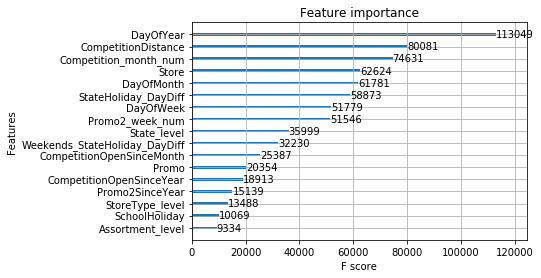

In [85]:
# xgboost模型特征重要性
xgb.plot_importance(model_xgboost);

In [86]:
# XGBoost模型预测训练集
xgb_y_train_pre = model_xgboost.predict(xgb.DMatrix(X_train[features]))
# 评估XGBoost在训练集上的性能
rmspe(np.expm1(xgb_y_train_pre),np.expm1(y_train.values))

0.07282719138803848

In [87]:
# XGBoost模型预测验证集
xgb_y_valid_pre = model_xgboost.predict(xgb.DMatrix(X_valid[features]))
# 评估XGBoost在验证集上的性能
rmspe(np.expm1(xgb_y_valid_pre),np.expm1(y_valid.values))

0.12622873676172355

——>通过曲线图展示模型在验证集上的拟合效果

In [88]:
# 不同连锁店实际日销售额和预测日销售额曲线图绘制函数
def store_sales_plot(df,num):
    fig = plt.figure(figsize=(16,4))
    sns.lineplot(df[df['Store']==num]['Date'],df[df['Store']==num]['Sales'],label='Sales')
    sns.lineplot(df[df['Store']==num]['Date'],df[df['Store']==num]['PreSales'],label='PreSales');

——>RFR模型：

In [89]:
# 验证集中不同店铺每天的实际和预测日销售额
valid_pre_sales = pd.Series(np.expm1(rf_y_valid_pre),index=X_valid.index,name='PreSales')
rf_valid = valid[['Date','Store','Open','Sales']].join(valid_pre_sales,how='left')
# 未营业的店铺销量认为是0
rf_valid.loc[rf_valid['Open']==0,'PreSales'] = 0

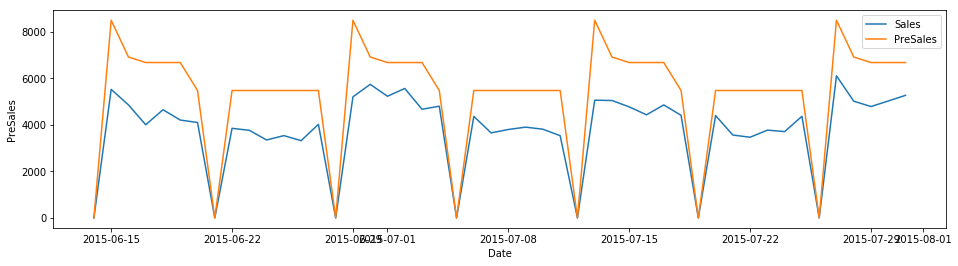

In [90]:
# 以1号店为例，展示验证集在RFR模型下的拟合效果
store_sales_plot(rf_valid,1)

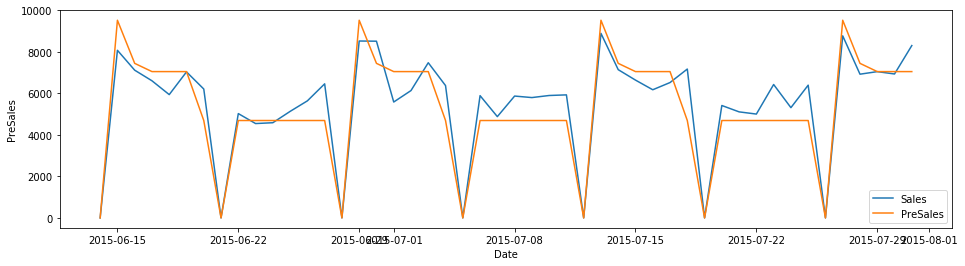

In [91]:
# 以66号店为例，展示验证集在RFR模型下的拟合效果
store_sales_plot(rf_valid,66)

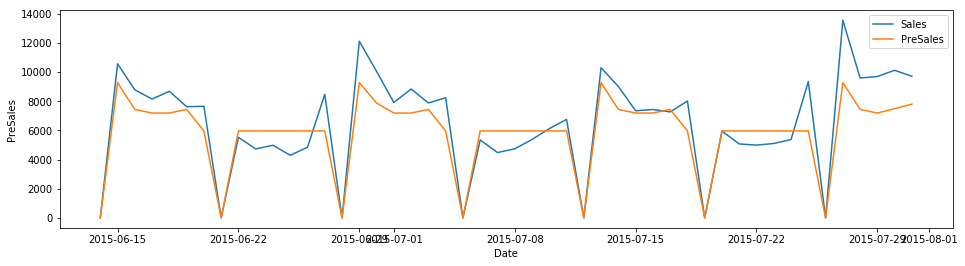

In [92]:
# 以666号店为例，展示验证集在RFR模型下的拟合效果
store_sales_plot(rf_valid,666)

——>XGBoost模型：

In [93]:
# 验证集中不同店铺每天的实际和预测日销售额
valid_pre_sales_1 = pd.Series(np.expm1(xgb_y_valid_pre),index=X_valid.index,name='PreSales')
xgb_valid = valid[['Date','Store','Open','Sales']].join(valid_pre_sales_1,how='left')
# 未开门的店铺销量为0
xgb_valid.loc[xgb_valid['Open']==0,'PreSales'] = 0

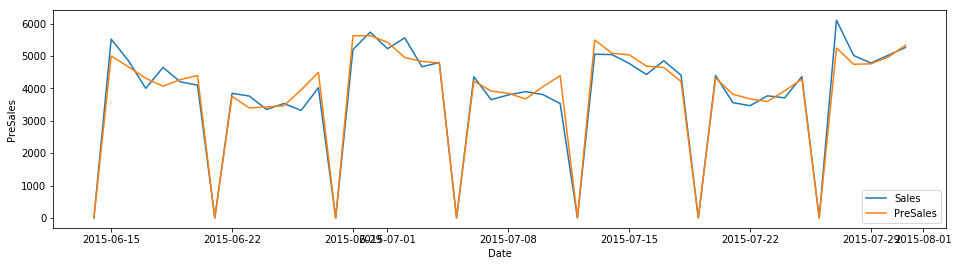

In [94]:
# 以1号店为例，展示验证集在XGBoost模型下的拟合效果
store_sales_plot(xgb_valid,1)

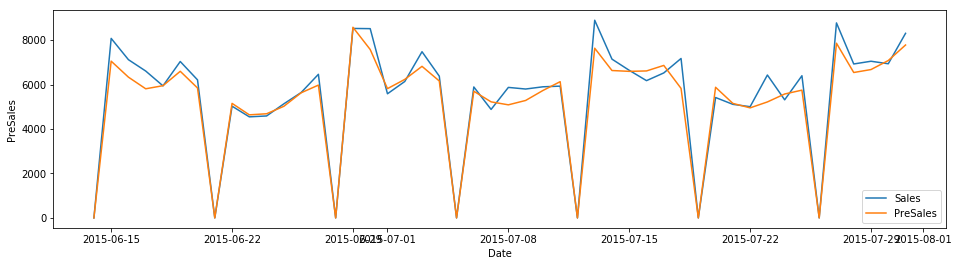

In [95]:
# 以66号店为例，展示验证集在XGBoost模型下的拟合效果
store_sales_plot(xgb_valid,66)

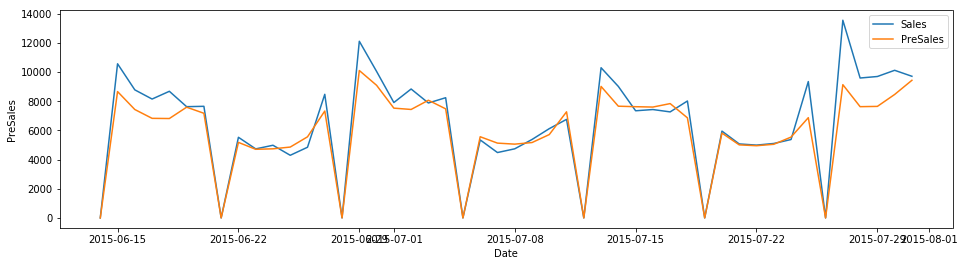

In [96]:
# 以666号店为例，展示验证集在XGBoost模型下的拟合效果
store_sales_plot(xgb_valid,666)

第八步：XGBoost模型预测测试集

In [97]:
# XGBoost模型预测测试集
y_test_pre = model_xgboost.predict(xgb.DMatrix(X_test[features]))

In [98]:
# 测试集中不同店铺每天的实际和预测日销售额
test_pre_sales = pd.Series(np.expm1(y_test_pre),index=X_test.index,name='PreSales')
xgb_test = test[['Date','Store','Open']].join(test_pre_sales,how='left')
# 未开门的店铺销量为0
xgb_test.loc[xgb_test['Open']==0,'PreSales'] = 0

In [99]:
# 创建提交文件sub
df_sub_1 = pd.read_csv('sample_submission.csv')
df_sub_2 = xgb_test[['Store','Date','PreSales']].reset_index().drop(['index'],axis=1)
sub = pd.concat([df_sub_1,df_sub_2],axis=1)[['Id','PreSales']]
sub.rename(columns={'PreSales':'Sales'},inplace=True)

In [100]:
# 查看提交文件
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 2 columns):
Id       41088 non-null int64
Sales    41088 non-null float32
dtypes: float32(1), int64(1)
memory usage: 481.6 KB


In [101]:
# 将提交文件保存为csv
sub.to_csv('submission.csv',index=False)